# Fine-Tunning Large Language Models (LLMs)

Fine-tuning in AI refers to the process of taking a pre-trained model and further training it on a specific task or dataset to improve its performance for that particular domain. It involves adjusting the model's parameters using a smaller, task-specific dataset, leveraging the knowledge gained during its initial training. Fine-tuning is a crucial step to adapt pre-trained models, such as large language models, to specific applications, achieving better accuracy and relevance in real-world scenarios.<br>
<b>Note:</b> The key upside of this approach is that models can achieve better performance while requiring (far) fewer manually labeled examples compared to models that solely rely on supervised training.

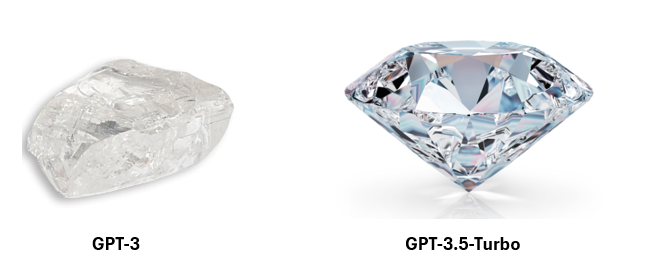

In [2]:
Image("fine_tunning.png")

# Why Fine-Tune?
Fine-tuning not only improves the performance of a base model, but a smaller (fine-tuned) model can often outperform larger (more expensive) models on the set of tasks on which it was trained

# 3 Ways to Fine-tune

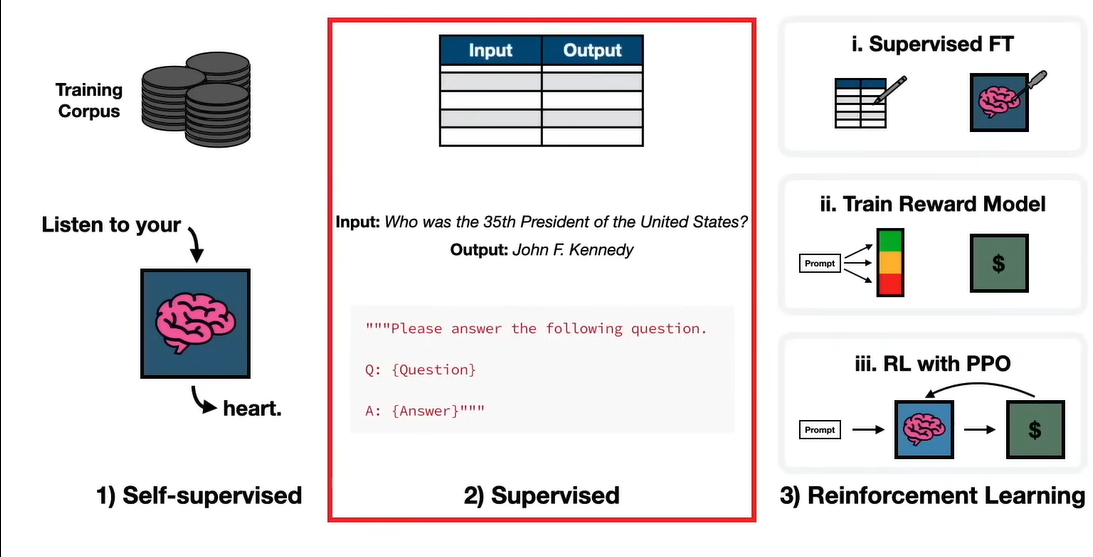

In [3]:
Image("type.png")

There are 3 generic ways one can fine-tune a model: self-supervised, supervised, and reinforcement learning. These are not mutually exclusive in that any combination of these three approaches can be used in succession to fine-tune a single model.
## 1.Self-supervised Learning
Self-supervised learning consists of training a model based on the inherent structure of the training data. In the context of LLMs, what this typically looks like is given a sequence of words (or tokens, to be more precise), predict the next word (token).

While this is how many pre-trained language models are developed these days, it can also be used for model fine-tuning. A potential use case of this is developing a model that can mimic a person’s writing style given a set of example texts.

## 2.Supervised Learning
The next, and perhaps most popular, way to fine-tune a model is via supervised learning. This involves training a model on input-output pairs for a particular task. An example is instruction tuning, which aims to improve model performance in answering questions or responding to user prompts
The key step in supervised learning is curating a training dataset. A simple way to do this is to create question-answer pairs and integrate them into a prompt template

## 3.Reinforcement Learning
Finally, one can use reinforcement learning (RL) to fine-tune models. RL uses a reward model to guide the training of the base model. This can take many different forms, but the basic idea is to train the reward model to score language model completions such that they reflect the preferences of human labelers . The reward model can then be combined with a reinforcement learning algorithm (e.g. Proximal Policy Optimization (PPO)) to fine-tune the pre-trained model.

An example of how RL can be used for model fine-tuning is demonstrated by OpenAI’s InstructGPT models, which were developed through 3 key steps .

Generate high-quality prompt-response pairs and fine-tune a pre-trained model using supervised learning. (13k training prompts) Note: One can (alternatively) skip to step 2 with the pre-trained model 
Use the fine-tuned model to generate completions and have human-labelers rank responses based on their preferences. Use these preferences to train the reward model. (33k training prompts)
Use the reward model and an RL algorithm (e.g. PPO) to fine-tune the model further. (31k training prompts)

# 3 Options for Parameter Training

## 1: Retrain all parameters

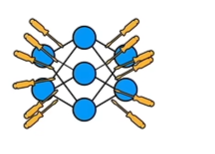

In [4]:
Image("1.png")

When it comes to fine-tuning a model with <b>100M-100B</b> parameters, one needs to be thoughtful of computational costs. Toward this end, an important question is — which parameters do we (re)train?

The first option is to train all internal model parameters (called full parameter tuning) . While this option is simple (conceptually), it is the most computationally expensive. Additionally, a known issue with full parameter tuning is the phenomenon of catastrophic forgetting. This is where the model “forgets” useful information it “learned” in its initial training

## 2: Transfer Learning

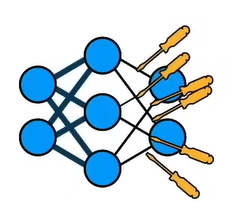

In [5]:
Image("2_.png")


The big idea with transfer learning (TL) is to preserve the useful representations/features the model has learned from past training when applying the model to a new task. This generally consists of dropping “the head” of a neural network (NN) and replacing it with a new one (e.g. adding new layers with randomized weights). Note: The head of an NN includes its final layers, which translate the model’s internal representations to output values.

While leaving the majority of parameters untouched mitigates the huge computational cost of training an LLM, TL may not necessarily resolve the problem of catastrophic forgetting. To better handle both of these issues, we can turn to a different set of approaches.

## 3: Parameter Efficient Fine-Tunning (PEFT)

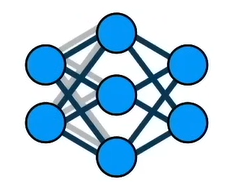

In [7]:
Image("3.png")



PEFT involves augmenting a base model with a relatively small number of trainable parameters. The key result of this is a fine-tuning methodology that demonstrates comparable performance to full parameter tuning at a tiny fraction of the computational and storage cost.

PEFT encapsulates a family of techniques, one of which is the popular LoRA (Low-Rank Adaptation) method . The basic idea behind LoRA is to pick a subset of layers in an existing model and modify their weights 

# Low-Rank Adaptation (LoRA) 
LoRA (Low-Rank Adaptation of Large Language Models) is a popular and lightweight training technique that significantly reduces the number of trainable parameters. It works by inserting a smaller number of new weights into the model and only these are trained. This makes training with LoRA much faster, memory-efficient, and produces smaller model weights (a few hundred MBs), which are easier to store and share. LoRA can also be combined with other training techniques like DreamBooth to speedup training.

In [1]:
from IPython.display import Image

In [2]:
!pip install datasets

In [3]:
!pip install peft

In [4]:
!pip install evaluate

In [5]:
!pip install accelerate

In [6]:
!pip install accelerate -U

In [7]:
!pip install accelerate==0.20.1

  Using cached accelerate-0.20.1-py3-none-any.whl (227 kB)
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.25.0
    Uninstalling accelerate-0.25.0:
      Successfully uninstalled accelerate-0.25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.7.1 requires accelerate>=0.21.0, but you have accelerate 0.20.1 which is incompatible.


In [8]:
!pip install transformers[torch]

  Using cached accelerate-0.25.0-py3-none-any.whl (265 kB)
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.20.1
    Uninstalling accelerate-0.20.1:
      Successfully uninstalled accelerate-0.20.1


# Import Libraries

In [9]:
from datasets import load_dataset, DatasetDict, Dataset

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer)

from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
import evaluate
import torch
import numpy as np

# Base Model

In [10]:
model_checkpoint = 'distilbert-base-uncased'

# define label maps
id2label = {0: "Negative", 1: "Positive"}
label2id = {"Negative":0, "Positive":1}

# generate classification model from model_checkpoint
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=2, id2label=id2label, label2id=label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Load Dataset

In [11]:
dataset = load_dataset('shawhin/imdb-truncated')
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 1000
    })
})

# Data Preprocessing

In [12]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

# add pad token if none exists
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

In [13]:
def tokenize_function(examples):
    # extract text
    text = examples["text"]

    #tokenize and truncate text
    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        text,
        return_tensors="np",
        truncation=True,
        max_length=512
    )

    return tokenized_inputs
if tokenizer.pad_token is None:
  tokenizer.add_special_tokens({'pad_token':'[PAD]'})
  model.resize_token_embeddings(len(tokenizer))
tokenized_dataset = dataset.map(tokenize_function,batched=True)
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 1000
    })
})

In [14]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Evaluation Metrics

In [15]:
accuracy = evaluate.load("accuracy")
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    return {"accuracy": accuracy.compute(predictions=predictions, references=labels)}

# Untrained Model Performance

In [16]:

text_list = ["It was good.", "Not a fan, don't recommed.", "Better than the first one.", "This is not worth watching even once.", "This one is a pass."]

print("Untrained model predictions:")
print("----------------------------")
for text in text_list:
    inputs = tokenizer.encode(text, return_tensors="pt")
    logits = model(inputs).logits
    predictions = torch.argmax(logits)
    print(text + " - " + id2label[predictions.tolist()])

Untrained model predictions:
----------------------------
It was good. - Negative
Not a fan, don't recommed. - Negative
Better than the first one. - Negative
This is not worth watching even once. - Negative
This one is a pass. - Negative


# Fine-Tunning with LoRA

In [17]:
peft_config = LoraConfig(task_type="SEQ_CLS",
                        r=4,
                        lora_alpha=32,
                        lora_dropout=0.01,
                        target_modules = ['q_lin'])

In [18]:
peft_config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='SEQ_CLS', inference_mode=False, r=4, target_modules={'q_lin'}, lora_alpha=32, lora_dropout=0.01, fan_in_fan_out=False, bias='none', modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={})

In [19]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 628,994 || all params: 67,584,004 || trainable%: 0.9306847223789819


In [20]:
lr = 1e-3
batch_size = 4
num_epochs = 10
training_args = TrainingArguments(
    output_dir= model_checkpoint + "-lora-text-classification",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [21]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator, # this will dynamically pad examples in each batch to be equal length
    compute_metrics=compute_metrics,
)

# train model
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.417450,{'accuracy': 0.861}
2,0.420800,0.452025,{'accuracy': 0.865}
3,0.420800,0.479757,{'accuracy': 0.895}
4,0.177300,0.752658,{'accuracy': 0.87}
5,0.177300,0.710757,{'accuracy': 0.886}
6,0.062800,0.822930,{'accuracy': 0.882}
7,0.062800,0.907235,{'accuracy': 0.887}
8,0.011000,0.898284,{'accuracy': 0.888}
9,0.011000,0.916326,{'accuracy': 0.887}
10,0.008400,0.911427,{'accuracy': 0.89}


Trainer is attempting to log a value of "{'accuracy': 0.861}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.865}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.895}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.87}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.886}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This in

TrainOutput(global_step=2500, training_loss=0.13606003589630128, metrics={'train_runtime': 461.6144, 'train_samples_per_second': 21.663, 'train_steps_per_second': 5.416, 'total_flos': 1113026652407424.0, 'train_loss': 0.13606003589630128, 'epoch': 10.0})